In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Linear and Logistic Regression

- Regression is a technique for supervised learning that is based on strong statistical assumptions about the underlying data. Linear and logistic regression are just two different assumptions on the data
- Regression can be used when the assumptions are not met, but then it needs to be graded based on _performance on the test data_. P-values, F-scores, etc.. depend on the assumptions being true.

## Linear Regression

Let $y \in \mathbb{R}$ be a random variable (the target) and $X = x_1, \ldots, x_p$ be a set of _independent_ variables (the predictors). Then
$$
y \sim \cal{N}(\mu, \sigma)
$$
where 
$$
\mu = \mu(X) = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_p x_p
$$

### Linear Regression Test Data

Let's generate some sample data that matches the assumptions exactly.

1. Set p = 3
2. Choose a formula for $\mu(X)$
$$
\mu(X) = 5 - 9 x_1 + 3 x_2 + 2 x_3
$$

Generate a 100x3 data frame of random numbers

In [3]:
X = pd.DataFrame(np.random.rand(100,3))

The target (response) is a linear function of the features, plus some gaussian noise.

In [4]:
X.head()

,0,1,2
0,0.834211,0.232512,0.097900
1,0.630437,0.552745,0.385326
2,0.301526,0.510103,0.044230
3,0.988131,0.808715,0.825096
4,0.266662,0.024382,0.199670


In [8]:
sigma = 0.1
def make_target(row, sigma):
        x1, x2, x3 = row[0], row[1], row[2]
        mu = 5 - 9*x1 + 3*x2 + 2*x3
        y = np.random.normal(mu, sigma)
        return y
    
y = X.apply(lambda row: make_target(row, sigma), axis = 1)

In [9]:
y.head()

0   -1.696840
1    1.807866
2    3.863586
3    0.171248
4    3.187623
dtype: float64

In [10]:
y.shape

(100,)

### Recover the formula using linear regression

In [ ]:
# Reverse engineer the previous

In [12]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression() #instatiate
linreg.fit(X, y) #fit



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Intercept

In [13]:
linreg.intercept_

4.9805044890227474

Coefficients

In [14]:
linreg.coef_ # should match (9,3,2)

array([-8.97814622,  2.99952442,  1.99547238])

Plot predicted vs actual

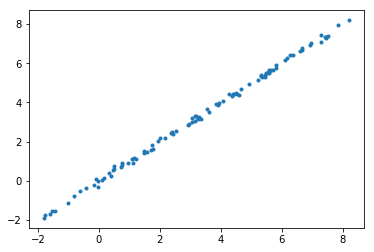

In [15]:
pred = linreg.predict(X)
plt.plot(pred, y, '.')

R-squared

In [16]:
linreg.score(X,y)

0.99865210601855103

## Logistic Regression

Let $y \in \{0, 1\}$ be a random variable (the target) and $X = x_1, \ldots, x_n$ be a set of _independent_ variables (the predictors). Then
$$
y \sim \cal{Ber}(p)
$$
where
$$
p = p(X) = f(w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_n x_n)
$$
and $f$ is the _logistic function_
$$
f(t) = \frac{1}{1 + e^{-t}}
$$

In [17]:
# Trying to predict a bianry answer (yes or no, 0 or 1)
# give y a standard distribution but doesn't make sense to be normally distributed. so choose burnoli 
# very similar to minear regression but our assumed distributing of underlying data has changed 

### Why Sigmoid?

We choose the sigmoid function because it is a transformation of the whole real line to the interval (0, 1). That is, it turns real numbers into probabilities

In [18]:
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

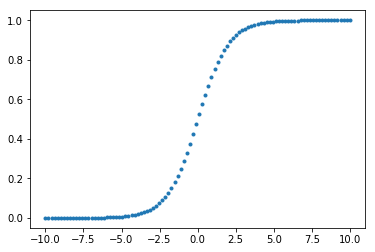

In [19]:
pts = np.linspace(-10, 10, 100)
sig = sigmoid(pts)
plt.plot(pts, sig, '.')

### Logistic Regression Test Data

Let's generate some sample data that matches the assumptions exactly.

1. Set n = 3
2. Choose a formula for $p(X)$
$$
p(X) = f(5 - 9 x_1 + 3 x_2 + 2 x_3)
$$

#### Exercise: Generate logistic regression data according to the model above.

1. Use the same feature data (X) as before.
2. Delete the target column (use `del X['target']`)
3. Make a new target column with values in {0, 1} that is distributed Bernoulli, conditioned on the feature matrix

In [29]:
X = pd.DataFrame(np.random.rand(100,3))

sigma = 0.1
def make_target(row):
    x1, x2, x3 = row[0], row[1], row[2]
    p = sigmoid(5 - 9*x1 + 3*x2 + 2*x3)
    return np.random.rand() < p


y = X.apply(make_target, axis=1) 

In [30]:
y.head()

0     True
1    False
2     True
3    False
4     True
dtype: bool

#### Recover coefficients

In [49]:
from sklearn.linear_model import LogisticRegression

# Fit logistic model
logit = LogisticRegression(C=1e18)
logit.fit(X,y)


LogisticRegression(C=1e+18, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
# Intercepts
logit.intercept_

array([ 5.00077571])

In [51]:
# coefficients
logit.coef_

array([[-9.82894759,  3.63927214,  1.66338867]])

In [53]:
# R squared 
logit.score(X,y)

0.89000000000000001

#### Plot predicted vs actual

In [54]:
results = pd.DataFrame({
        'wTx': X.apply(lambda row: np.dot(row, logit.coef_.flatten()), axis=1),
        'Predicted Probability': logit.predict_proba(X)[:,1],
        'Actual': X['target']
    })

ax = results.plot(x='wTx', y='Predicted Probability', kind='scatter', 
                  label = 'Predicted', color='lightblue')
results.plot(x='wTx', y='Actual', kind='scatter', ax=ax, label='Actual')

KeyError: 'target'

# Regularization

Regularization is a means for preventing _overfitting_.

For any type of regression, one learns the model parameters by:

1. Assume the probabilistic model is correct.
2. Compute the _likelihood_ of each data point for a given set of parameters $w_0, \ldots, w_p$. (just evaluate the PDF at that point and target value)
3. Choose the set of parameters that maximizes the total likelihood. (or, equivalently, minimizes the log-likelihood)

For linear regression, it turns out that ${\cal l} (X) \sim ||w^T x - y||^2$. So maximizing the likelihood is the same as minimizing the mean-squared error.

For logistic regression,
$$
{\cal l} (x) := -y \log(f(w^T x)) - (1 - y) \log(1 - f(w^Tx))
$$

In either case, regularization just means that instead of directly minimizing ${\cal L}(X)$, we also add a penalty on the size of coefficients.

#### L1 (Lasso) Regularization

Find $w$ that minimizes 
$$
{\cal l}(X) + \lambda \sum_{i=1}^p |w_i|
$$

#### L2 (Ridge) Regularization

Find $w$ that minimizes 
$$
{\cal l}(X) + \lambda \sum_{i=1}^p ||w_i||^2
$$

#### Elastic Net Regularization

Find $w$ that minimizes 
$$
{\cal l}(X) + (1 - \alpha) \cdot \lambda \sum_{i=1}^p |w_i|^2 + \alpha \cdot \lambda \sum_{i=1}^p ||w_i||
$$

# Application: Crime Data

Terminal

conda update scikit-learn

In [87]:
from sklearn.model_selection import train_test_split

# Load some crime data
headers = pd.read_csv('comm_names.txt', squeeze=True)
headers = headers.apply(lambda s: s.split()[1])
crime = (pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data', 
                    header=None, na_values=['?'], names=headers)
         .iloc[:, 5:]
         .dropna()
         )

# Set target and predictors
target = 'ViolentCrimesPerPop'
predictors = [c for c in crime.columns if not c == target]

# Train/test split
train_df, test_df = train_test_split(crime, random_state=2)  

# Wide data set so easy to overfit with logistic regression

In [88]:
train_df.shape

(239, 122)

In [89]:
test_df.shape

(80, 122)

In [90]:
train_df.head()

,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
54,0.23,0.28,0.76,0.08,0.01,0.32,0.37,0.22,0.61,0.09,...,0.08,0.16,0.29,0.09,0.01,0.56,0.0,1.00,0.12,0.56
41,0.58,0.01,0.83,0.13,0.21,0.44,0.49,0.29,0.25,0.06,...,0.05,0.16,0.20,0.06,0.04,0.22,0.5,0.59,0.48,0.09
13,0.47,0.74,0.37,0.08,0.05,0.49,0.57,0.40,0.34,0.27,...,0.63,0.07,0.08,0.37,0.04,0.74,0.5,0.84,0.09,0.25
1,0.45,0.83,0.34,0.04,0.01,0.48,0.53,0.36,0.37,0.30,...,0.39,0.12,0.09,0.04,0.01,0.00,0.0,0.36,0.01,0.35
19,0.43,0.04,0.89,0.09,0.06,0.45,0.48,0.31,0.46,0.13,...,0.16,0.12,0.07,0.04,0.01,0.81,1.0,0.56,0.09,0.63


## Exercise: 

1. Fit a linear regression model on train_df. The goal is to predict 'ViolentCrimesPerPop' from the other columns. What is the r-squared on the train data? What about the test data?
2. Also fit each of a ridge, lasso, and elastic net regression on the same data. Use the functions RidgeCV, LassoCV, and ElasticNetCV to cross-validate and find the best values of $\lambda$ and $\alpha$. Do this using only _the training set_
3. Which model performs the best? Answer this question using _the test set_.

### Linear Regression

In [91]:
linReg = LinearRegression()
linreg.fit(train_df[predictors], train_df[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [92]:
linreg.intercept_

1.1395646980719445

R-squared on training data

In [94]:
linreg.score(train_df[predictors],train_df[target])

0.82318616940316736

R-squared on test data

In [95]:
linreg.score(test_df[predictors], test_df[target])

0.50916546685875996

### Ridge

In [96]:
from sklearn.linear_model import RidgeCV

rr = RidgeCV(alphas=np.power(10., np.arange(-5,6)))
rr.fit(train_df[predictors], train_df[target])
print 'train R2', rr.score(train_df[predictors], train_df[target])
print 'test R2', rr.score(test_df[predictors], test_df[target])
print 'wvec:', rr.coef_
print 'lambda', rr.alpha_


train R2 0.665866858416
test R2 0.714273247025
wvec: [-0.00227582  0.08230379 -0.06412292 -0.00772165  0.02677898  0.00539564
 -0.00832168 -0.00186947  0.01439694  0.00257869  0.01556309 -0.01717738
 -0.02177307 -0.03498826 -0.04495981  0.01074812  0.02925941 -0.01492379
 -0.01026583 -0.00583042  0.00158234 -0.00677277 -0.00617339  0.01189401
  0.03467641  0.01648832 -0.0101469   0.01873815 -0.02907318 -0.00480109
 -0.01234768  0.03202148 -0.01993723 -0.05015593  0.0158556   0.00351489
 -0.00784046  0.0453326   0.02228998  0.03975416  0.04524221  0.00349481
 -0.06517959 -0.0720009  -0.05581412 -0.04688224  0.01883544  0.01143286
  0.00203689  0.08200217 -0.0111038  -0.00700924 -0.00657467  0.00702009
  0.019801    0.0014376   0.00874782  0.01676644  0.01652717  0.00231704
 -0.00248397  0.01872848  0.01136615 -0.00982044  0.00242297 -0.01496559
 -0.00881304  0.01721259  0.04152964 -0.0238116   0.03939913 -0.020133
 -0.01033917  0.04326436 -0.00789304 -0.0039359   0.0424721  -0.00996011


### Lasso

In [97]:
from sklearn.linear_model import LassoCV

lar = LassoCV(alphas=np.power(10., np.arange(-5,6)))
lar.fit(train_df[predictors], train_df[target])
print 'train R2', lar.score(train_df[predictors], train_df[target])
print 'test R2', lar.score(test_df[predictors], test_df[target])
print 'wvec:', lar.coef_
print 'lambda', lar.alpha_


train R2 0.684981811291
test R2 0.71670875777
wvec: [ 0.          0.08178776 -0.         -0.          0.09924475  0.
 -0.00765088 -0.          0.         -0.          0.         -0.         -0.
 -0.01205732 -0.19295059  0.          0.         -0.          0.          0.
 -0.         -0.         -0.          0.          0.11284783  0.         -0.
  0.         -0.1126499  -0.         -0.          0.04831336 -0.
 -0.10203154  0.          0.         -0.          0.01060783 -0.          0.
  0.          0.         -0.         -0.55131388 -0.         -0.          0.
  0.         -0.          0.08050905 -0.          0.         -0.          0.
  0.          0.          0.          0.          0.         -0.          0.
  0.          0.          0.          0.         -0.          0.          0.
  0.12383203 -0.          0.04124994 -0.          0.          0.02364541
 -0.          0.          0.01907677 -0.         -0.         -0.02212135
 -0.00156401 -0.         -0.         -0.         -0.    

/Users/mauracullen/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Elastic Net

In [112]:
from sklearn.linear_model import ElasticNetCV

en = ElasticNetCV(l1_ratio=[0.1,0.5, 0.7, 0.9, 0.95, 0.99,0.1])
en.fit(train_df[predictors], train_df[target])
print 'train R2', en.score(train_df[predictors], train_df[target])
print 'test R2', en.score(test_df[predictors], test_df[target])
print 'wvec:', en.coef_
print 'lambda', en.alpha_


train R2 0.650724087416
test R2 0.718658990765
wvec: [-0.          0.09899698 -0.07396257 -0.          0.02859735  0.         -0.
  0.          0.          0.          0.         -0.         -0.         -0.
 -0.04273575  0.          0.01680586 -0.         -0.         -0.         -0.
 -0.         -0.          0.          0.00025827  0.          0.
  0.01102043 -0.          0.         -0.          0.03104448 -0.
 -0.05750859  0.          0.         -0.          0.04502578  0.
  0.02583623  0.04411929  0.         -0.09329905 -0.10926846 -0.06306402
 -0.04312344  0.          0.          0.          0.1091917   0.         -0.
  0.          0.          0.          0.          0.          0.00246674
  0.00482013 -0.          0.          0.          0.         -0.          0.
 -0.         -0.          0.01391855  0.04955475 -0.0207441   0.04904405
 -0.         -0.          0.04575055 -0.         -0.          0.04482856
  0.         -0.         -0.         -0.         -0.         -0.         -0

## Exercise:

1. Make the following scatterplot
    - Each point corresponds to one predictor in the data
    - The x-value is the coefficient of that predictor under OLS regression
    - The y-value is the coefficient of that predictor using ridge regularization
2. Do the same for OLS vs Lasso, and OLS vs ElasticNet

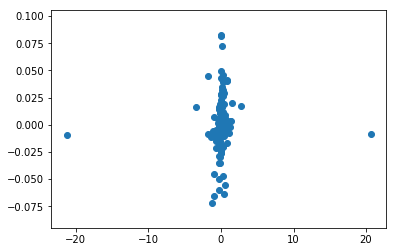

In [113]:
x = linreg.coef_
y = rr.coef_

plt.scatter(x,y)

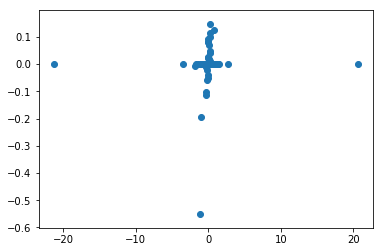

In [114]:
x = linreg.coef_
y = lar.coef_

plt.scatter(x,y)

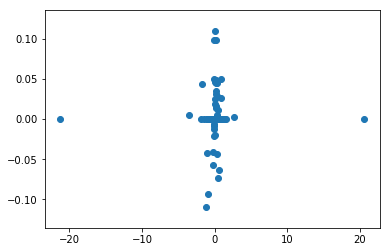

In [115]:
x = linreg.coef_
y = en.coef_

plt.scatter(x,y)

## Question: 

What is the story with the two 'large coefficients' found by OLS that are squashed by regularization? (You may have to do some digging)

## Question:

Can we tell from this process which predictors are _the most important_ for predicting violent crimes?